In [1]:
"""
Author: Bryan Bo Cao
Email: boca7588@colorado.edu or bo.cao-1@colorado.edu
Github Repo: https://github.com/BryanBo-Cao/neuralnets-deeplearning
Reference:
    https://github.com/tylersco/deep-neural-networks-art-images
    http://www.scipy-lectures.org/advanced/image_processing/
    
Autoencoder:
576	384	192	96	48	24	12	6(bottlenect)	12	24	48	96	192	384	576
"""
from scipy import misc
import scipy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import glob
import pandas as pd
import csv
import math
from __future__ import division, print_function, absolute_import
from data.img.ArtDataLoader import ArtData
import Plotter
from Plotter import plot_acc_distance
from Plotter import plot_acc_cosine
from Plotter import plot_prob_distance
from Plotter import plot_prob_cosine
from Plotter import plot_2lists
from Plotter import plot_4lists
from MySpearman import get_distance_prob_correlation
from MySpearman import get_cosine_prob_correlation
from MySpearman import get_distance_acc_correlation
from MySpearman import get_cosine_acc_correlation

from scipy.stats import spearmanr

In [2]:
from scipy import misc
art_data = ArtData()
art_data.load_all_data()
#art_data.load_images()
#art_data.load_metadata()

ArtData Initialized!
2592  images loaded!


In [3]:
#print(art_data.train_images.keys())
#Validate
print(art_data.alpha_pairs['same'][0][95])
print(art_data.beta_pairs['same'][0][95])

print(art_data.alpha_pairs['diff'][0][95])
print(art_data.beta_pairs['diff'][0][95])

2018-impressionist-16x16.jpg
2134-impressionist-16x16.jpg
1233-cubist-16x16.jpg
1185-cubist-16x16.jpg


In [4]:
print(art_data.train_images['0001-cubist-16x16.jpg'].shape)

(16, 16, 3)


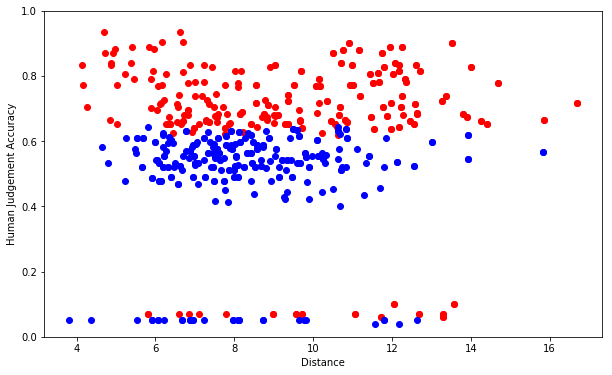

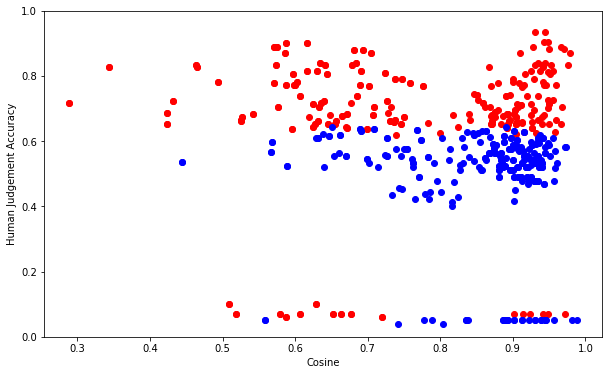

In [5]:
#Raw data - Human Judgement Accuracy
plot_acc_distance(art_data)
plot_acc_cosine(art_data)

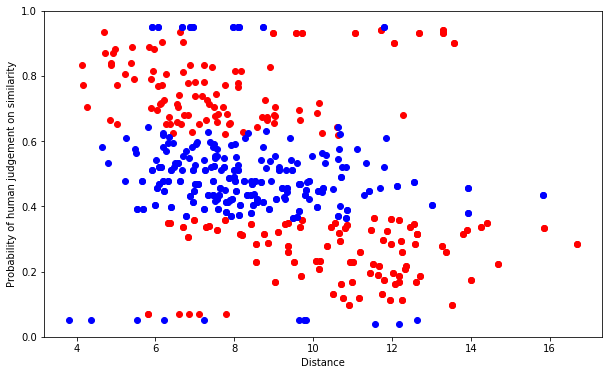

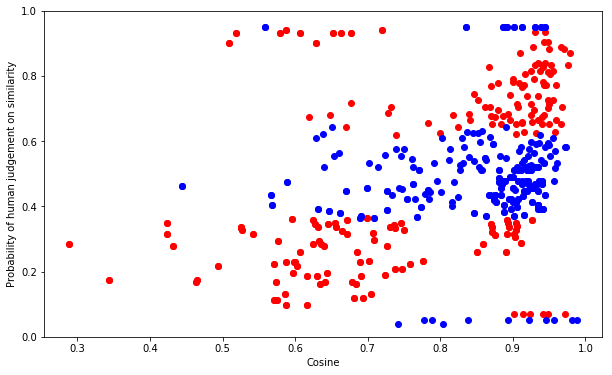

In [6]:
#Raw data - Probability of human judgement on similarity
plot_prob_distance(art_data)
plot_prob_cosine(art_data)

In [7]:
get_distance_prob_correlation(art_data)

SpearmanrResult(correlation=-0.4531196797090763, pvalue=1.6549967874513576e-30)

In [8]:
get_cosine_prob_correlation(art_data)

SpearmanrResult(correlation=0.42701803307779929, pvalue=6.2551843304760119e-27)

In [9]:
get_distance_acc_correlation(art_data)

SpearmanrResult(correlation=0.18460752476813316, pvalue=8.2212500213044036e-06)

In [10]:
get_cosine_acc_correlation(art_data)

SpearmanrResult(correlation=-0.23142047705047938, pvalue=1.9265333564185278e-08)

In [11]:
#start of autoencoder
'''
Reference:
https://github.com/MorvanZhou/tutorials/edit/master/tensorflowTUT/tf21_autoencoder/full_code.py
My tutorial website: https://morvanzhou.github.io/tutorials/
'''
learning_rate = 0.01
training_epochs = 1000
batch_size = 256
display_step = 5
# Network Parameters
n_input = 768 # image data input (img shape: 16*16*3)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

# hidden layer settings
n_hidden_1 = 576
n_hidden_2 = 384
n_hidden_3 = 192
n_hidden_4 = 96
n_hidden_5 = 48
n_hidden_6 = 24
n_hidden_7 = 12
n_hidden_8 = 6

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'encoder_h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'encoder_h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4])),
    'encoder_h5': tf.Variable(tf.random_normal([n_hidden_4, n_hidden_5])),
    'encoder_h6': tf.Variable(tf.random_normal([n_hidden_5, n_hidden_6])),
    'encoder_h7': tf.Variable(tf.random_normal([n_hidden_6, n_hidden_7])),
    'encoder_h8': tf.Variable(tf.random_normal([n_hidden_7, n_hidden_8])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_8, n_hidden_7])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_7, n_hidden_6])),
    'decoder_h3': tf.Variable(tf.random_normal([n_hidden_6, n_hidden_5])),
    'decoder_h4': tf.Variable(tf.random_normal([n_hidden_5, n_hidden_4])),
    'decoder_h5': tf.Variable(tf.random_normal([n_hidden_4, n_hidden_3])),
    'decoder_h6': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_2])),
    'decoder_h7': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h8': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'encoder_b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'encoder_b4': tf.Variable(tf.random_normal([n_hidden_4])),
    'encoder_b5': tf.Variable(tf.random_normal([n_hidden_5])),
    'encoder_b6': tf.Variable(tf.random_normal([n_hidden_6])),
    'encoder_b7': tf.Variable(tf.random_normal([n_hidden_7])),
    'encoder_b8': tf.Variable(tf.random_normal([n_hidden_8])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_7])),
    'decoder_b2': tf.Variable(tf.random_normal([n_hidden_6])),
    'decoder_b3': tf.Variable(tf.random_normal([n_hidden_5])),
    'decoder_b4': tf.Variable(tf.random_normal([n_hidden_4])),
    'decoder_b5': tf.Variable(tf.random_normal([n_hidden_3])),
    'decoder_b6': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b7': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b8': tf.Variable(tf.random_normal([n_input])),
}

# Building the encoder
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                   biases['encoder_b3']))
    layer_4 = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, weights['encoder_h4']),
                                   biases['encoder_b4']))
    layer_5 = tf.nn.sigmoid(tf.add(tf.matmul(layer_4, weights['encoder_h5']),
                                   biases['encoder_b5']))
    layer_6 = tf.nn.sigmoid(tf.add(tf.matmul(layer_5, weights['encoder_h6']),
                                   biases['encoder_b6']))
    layer_7 = tf.nn.sigmoid(tf.add(tf.matmul(layer_6, weights['encoder_h7']),
                                   biases['encoder_b7']))
    layer_8 = tf.nn.sigmoid(tf.add(tf.matmul(layer_7, weights['encoder_h8']),
                                   biases['encoder_b8']))
    return layer_8

# Building the decoder
def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                                   biases['decoder_b3']))
    layer_4 = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, weights['decoder_h4']),
                                   biases['decoder_b4']))
    layer_5 = tf.nn.sigmoid(tf.add(tf.matmul(layer_4, weights['decoder_h5']),
                                   biases['decoder_b5']))
    layer_6 = tf.nn.sigmoid(tf.add(tf.matmul(layer_5, weights['decoder_h6']),
                                   biases['decoder_b6']))
    layer_7 = tf.nn.sigmoid(tf.add(tf.matmul(layer_6, weights['decoder_h7']),
                                   biases['decoder_b7']))
    layer_8 = tf.nn.sigmoid(tf.add(tf.matmul(layer_7, weights['decoder_h8']),
                                   biases['decoder_b8']))
    return layer_8

In [12]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
y_bottleneck = encoder_op

# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


# Launch the graph
with tf.Session() as sess:
    # tf.initialize_all_variables() no long valid from
    # 2017-03-02 if using tensorflow >= 0.12
    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        init = tf.initialize_all_variables()
    else:
        init = tf.global_variables_initializer()
    sess.run(init)
    total_batch = int(len(art_data.train_images) / batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = art_data.next_batch(batch_size)  # max(x) = 1, min(x) = 0
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")
    
    #alpha
    encode_output_alpha_a = sess.run(
        y_bottleneck, feed_dict={X: art_data.alpha_set_flatten[0]})
    encode_output_alpha_b = sess.run(
        y_bottleneck, feed_dict={X: art_data.alpha_set_flatten[1]})
    
    encode_decode_output_alpha_a = sess.run(
        y_pred, feed_dict={X: art_data.alpha_set_flatten[0]})
    encode_decode_output_alpha_b = sess.run(
        y_pred, feed_dict={X: art_data.alpha_set_flatten[1]})
    
    #beta
    encode_output_beta_a = sess.run(
        y_bottleneck, feed_dict={X: art_data.beta_set_flatten[0]})
    encode_output_beta_b = sess.run(
        y_bottleneck, feed_dict={X: art_data.beta_set_flatten[1]})
    
    encode_decode_output_beta_a = sess.run(
        y_pred, feed_dict={X: art_data.beta_set_flatten[0]})
    encode_decode_output_beta_b = sess.run(
        y_pred, feed_dict={X: art_data.beta_set_flatten[1]})
  
encode_outout_alpha_a = encode_output_alpha_a.tolist()
encode_output_alpha_b = encode_output_alpha_b.tolist()

encode_decode_output_alpha_a = encode_decode_output_alpha_a.tolist()
encode_decode_output_alpha_b = encode_decode_output_alpha_b.tolist()

encode_output_beta_a = encode_output_beta_a.tolist()
encode_output_beta_b = encode_output_beta_b.tolist()

encode_decode_output_beta_a = encode_decode_output_beta_a.tolist()
encode_decode_output_beta_b = encode_decode_output_beta_b.tolist()

Epoch: 0001 cost= 0.260480404
Epoch: 0006 cost= 0.206015185
Epoch: 0011 cost= 0.189731970
Epoch: 0016 cost= 0.196231321
Epoch: 0021 cost= 0.189997360
Epoch: 0026 cost= 0.189594552
Epoch: 0031 cost= 0.192626402
Epoch: 0036 cost= 0.189983010
Epoch: 0041 cost= 0.191794470
Epoch: 0046 cost= 0.188714564
Epoch: 0051 cost= 0.186818287
Epoch: 0056 cost= 0.187402442
Epoch: 0061 cost= 0.189820111
Epoch: 0066 cost= 0.183004633
Epoch: 0071 cost= 0.193155289
Epoch: 0076 cost= 0.188284352
Epoch: 0081 cost= 0.189099237
Epoch: 0086 cost= 0.192129448
Epoch: 0091 cost= 0.189748943
Epoch: 0096 cost= 0.192003414
Epoch: 0101 cost= 0.188864827
Epoch: 0106 cost= 0.187298909
Epoch: 0111 cost= 0.187946424
Epoch: 0116 cost= 0.190246284
Epoch: 0121 cost= 0.182988644
Epoch: 0126 cost= 0.193164125
Epoch: 0131 cost= 0.188445568
Epoch: 0136 cost= 0.189921632
Epoch: 0141 cost= 0.193207070
Epoch: 0146 cost= 0.190747932
Epoch: 0151 cost= 0.192784309
Epoch: 0156 cost= 0.189665556
Epoch: 0161 cost= 0.187798142
Epoch: 016

In [13]:
#alpha

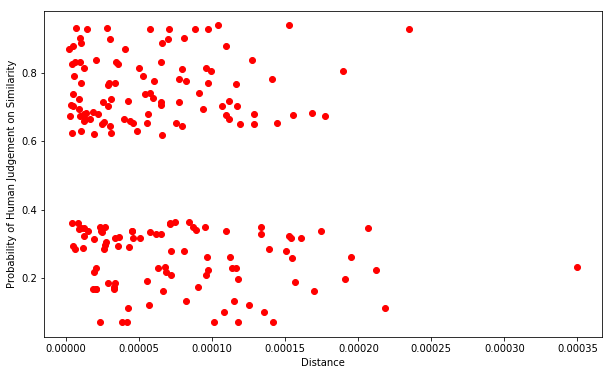

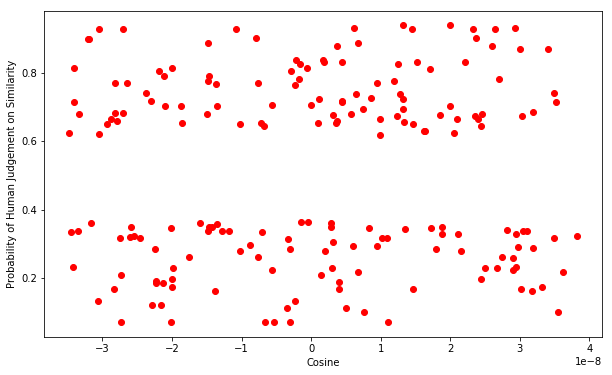

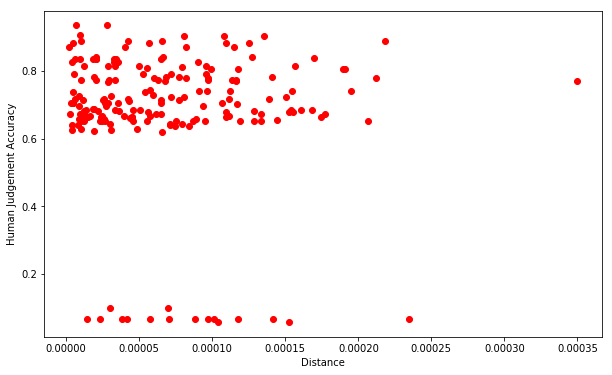

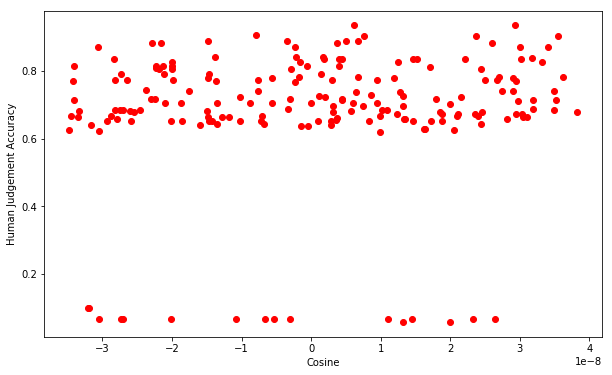

In [14]:
#alpha bottleneck output
#distance, cosine, prob_human_similarity, accuracy
encode_output_alpha_distance = art_data.get_distance_list_flatten(encode_output_alpha_a, encode_output_alpha_b)
encode_output_alpha_cosine = art_data.get_cosine_list_flatten(encode_output_alpha_a, encode_output_alpha_b)
plot_2lists(
    encode_output_alpha_distance, art_data.alpha_prob_human_similarity, 
    "Distance", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_output_alpha_cosine, art_data.alpha_prob_human_similarity,
    "Cosine", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_output_alpha_distance, art_data.alpha_accuracy, 
    "Distance", "Human Judgement Accuracy")
plot_2lists(
    encode_output_alpha_cosine, art_data.alpha_accuracy,
    "Cosine", "Human Judgement Accuracy")

In [15]:
#alpha bottleneck output
#distance, prob_human_similarity
spearmanr(encode_output_alpha_distance, art_data.alpha_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.18594124416313379, pvalue=0.0098169348547853114)

In [16]:
#alpha bottleneck output
#cosine, prob_human_similarity
spearmanr(encode_output_alpha_cosine, art_data.alpha_prob_human_similarity, axis=None)

SpearmanrResult(correlation=0.017859482061402154, pvalue=0.8057814071986148)

In [17]:
#alpha bottleneck output
#distance, accuracy
spearmanr(encode_output_alpha_distance, art_data.alpha_accuracy, axis=None)

SpearmanrResult(correlation=-0.0031275734778703186, pvalue=0.96565845313072374)

In [18]:
#alpha bottleneck output
#cosine, accuracy
spearmanr(encode_output_alpha_cosine, art_data.alpha_accuracy, axis=None)

SpearmanrResult(correlation=0.096010060662584107, pvalue=0.18526085348248114)

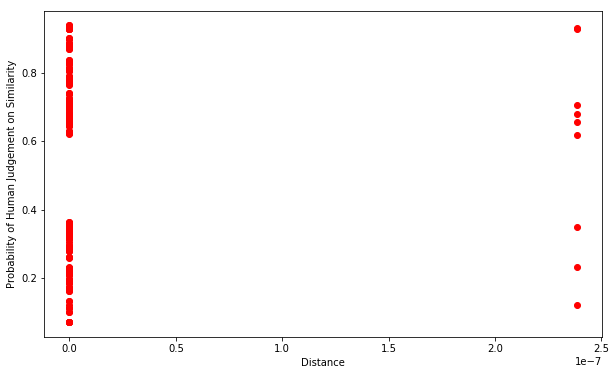

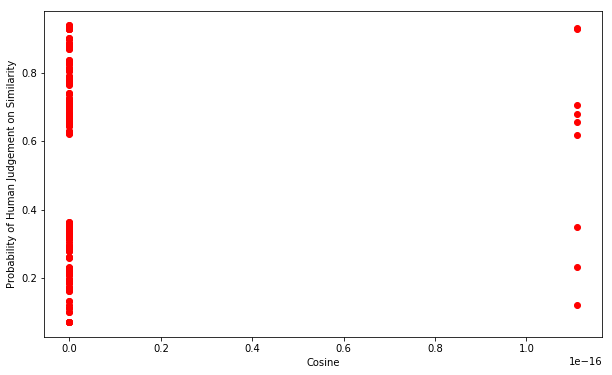

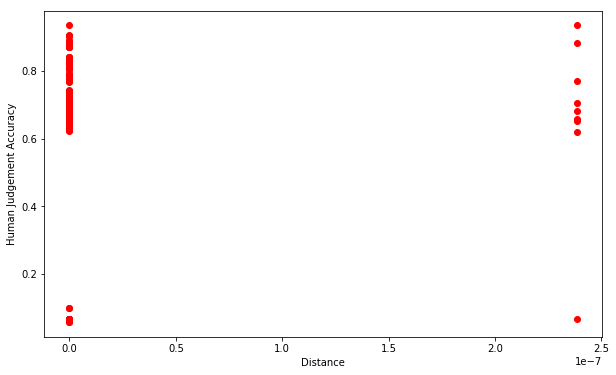

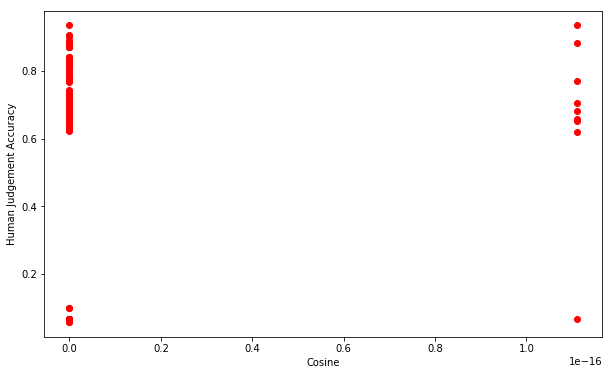

In [19]:
#alpha network output
#distance, cosine, prob_human_similarity, accuracy
encode_decode_output_alpha_distance = art_data.get_distance_list_flatten(
                    encode_decode_output_alpha_a, encode_decode_output_alpha_b)
encode_decode_output_alpha_cosine = art_data.get_cosine_list_flatten(
                    encode_decode_output_alpha_a, encode_decode_output_alpha_b)
plot_2lists(
    encode_decode_output_alpha_distance, art_data.alpha_prob_human_similarity,
    "Distance", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_decode_output_alpha_cosine, art_data.alpha_prob_human_similarity,
    "Cosine", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_decode_output_alpha_distance, art_data.alpha_accuracy,
    "Distance", "Human Judgement Accuracy")
plot_2lists(
    encode_decode_output_alpha_cosine, art_data.alpha_accuracy,
    "Cosine", "Human Judgement Accuracy")

In [20]:
#alpha, network output
#distance, prob_human_similarity
spearmanr(encode_decode_output_alpha_distance, art_data.alpha_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.017604873206028441, pvalue=0.80849647392638591)

In [21]:
#alpha, network output
#cosine, prob_human_similarity
spearmanr(encode_decode_output_alpha_cosine, art_data.alpha_prob_human_similarity, axis=None)

SpearmanrResult(correlation=0.043573516690344614, pvalue=0.54842969753964499)

In [22]:
#alpha, network output
#distance, accuracy
spearmanr(encode_decode_output_alpha_distance, art_data.alpha_accuracy, axis=None)

SpearmanrResult(correlation=-0.011222213050554805, pvalue=0.87722418644271416)

In [23]:
#alpha, network output
#cosine, accuracy
spearmanr(encode_decode_output_alpha_cosine, art_data.alpha_accuracy, axis=None)

SpearmanrResult(correlation=-0.04202788716688631, pvalue=0.56271837319829054)

In [24]:
#beta

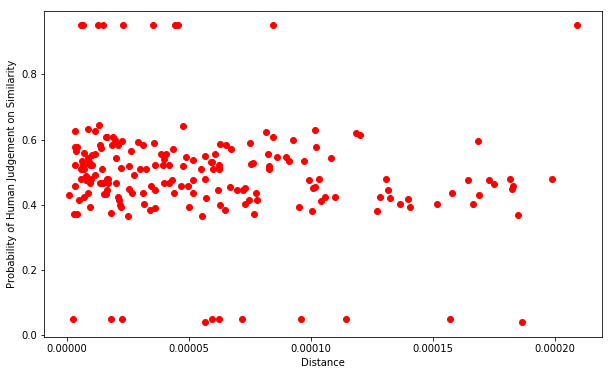

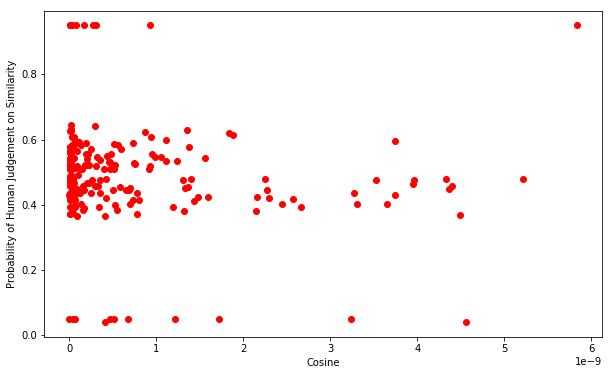

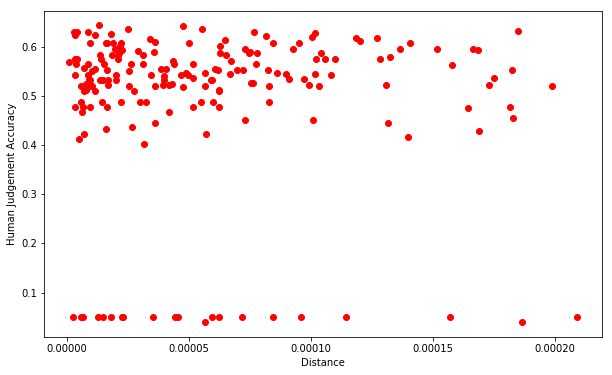

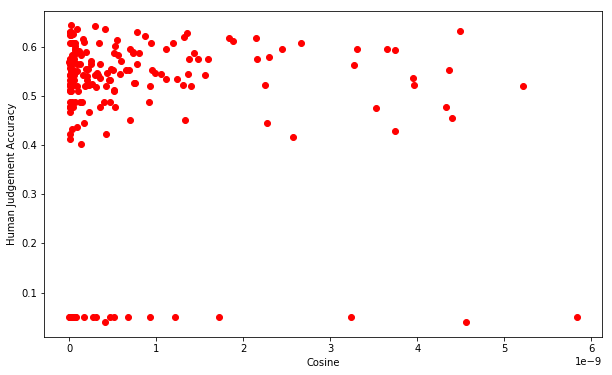

In [25]:
#beta, bottleneck output
#distance, cosine, prob_human_similarity, accuracy
encode_output_beta_distance = art_data.get_distance_list_flatten(encode_output_beta_a, encode_output_beta_b)
encode_output_beta_cosine = art_data.get_cosine_list_flatten(encode_output_beta_a, encode_output_beta_b)
plot_2lists(
    encode_output_beta_distance, art_data.beta_prob_human_similarity,
    "Distance", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_output_beta_cosine, art_data.beta_prob_human_similarity,
    "Cosine", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_output_beta_distance, art_data.beta_accuracy,
    "Distance", "Human Judgement Accuracy")
plot_2lists(
    encode_output_beta_cosine, art_data.beta_accuracy,
    "Cosine", "Human Judgement Accuracy")

In [26]:
#beta, bottleneck output
#distance, prob_human_similarity
spearmanr(encode_output_beta_distance, art_data.beta_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.19491853343918497, pvalue=0.0067431498940649214)

In [27]:
#beta, bottleneck output
#cosine, prob_human_similarity
spearmanr(encode_output_beta_cosine, art_data.beta_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.19122997798023192, pvalue=0.0078833948697616413)

In [28]:
#beta, bottleneck output
#distance, accuracy
spearmanr(encode_output_beta_distance, art_data.beta_accuracy, axis=None)

SpearmanrResult(correlation=0.032625247404946281, pvalue=0.65326120127641163)

In [29]:
#beta, bottleneck output
#cosine, accuracy
spearmanr(encode_output_beta_cosine, art_data.beta_accuracy, axis=None)

SpearmanrResult(correlation=0.035619945986204833, pvalue=0.62378212936818667)

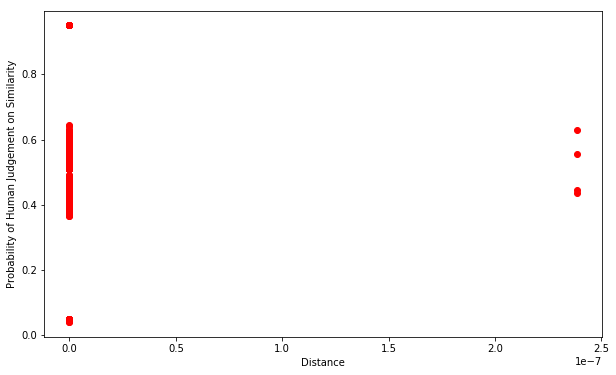

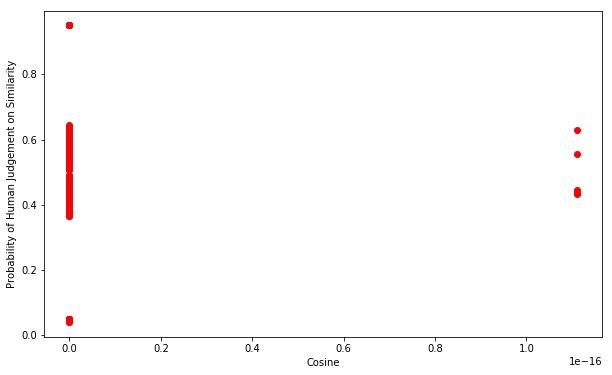

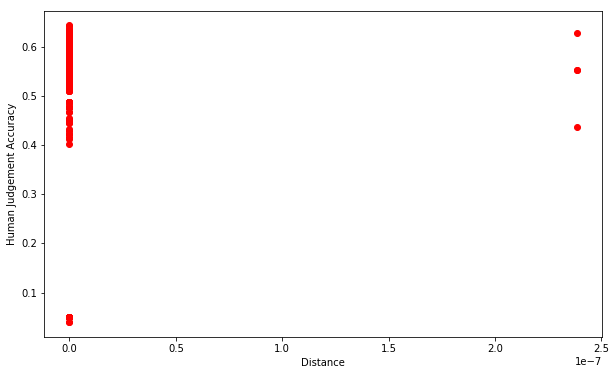

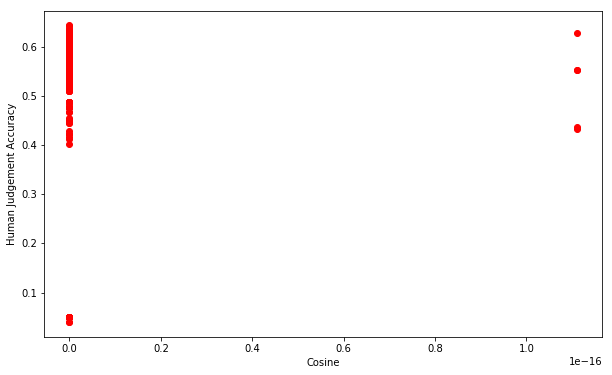

In [30]:
#beta, network output
#distance, cosine, prob_human_similarity, accuracy
encode_decode_output_beta_distance = art_data.get_distance_list_flatten(
                    encode_decode_output_beta_a, encode_decode_output_beta_b)
encode_decode_output_beta_cosine = art_data.get_cosine_list_flatten(
                    encode_decode_output_beta_a, encode_decode_output_beta_b)
plot_2lists(
    encode_decode_output_beta_distance, art_data.beta_prob_human_similarity,
    "Distance", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_decode_output_beta_cosine, art_data.beta_prob_human_similarity,
    "Cosine", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_decode_output_beta_distance, art_data.beta_accuracy,
    "Distance", "Human Judgement Accuracy")
plot_2lists(
    encode_decode_output_beta_cosine, art_data.beta_accuracy,
    "Cosine", "Human Judgement Accuracy")

In [31]:
#beta, network output
#distance, prob_human_similarity
spearmanr(encode_decode_output_beta_distance, art_data.beta_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.093850110416058369, pvalue=0.19539158761095571)

In [32]:
#beta, network output
#cosine, prob_human_similarity
spearmanr(encode_decode_output_beta_cosine, art_data.beta_prob_human_similarity, axis=None)

SpearmanrResult(correlation=0.0082627617497985518, pvalue=0.90943875681626096)

In [33]:
#beta, network output
#distance, accuracy
spearmanr(encode_decode_output_beta_distance, art_data.beta_accuracy, axis=None)

SpearmanrResult(correlation=0.02328002508786111, pvalue=0.74857833634091409)

In [34]:
#beta, network output
#cosine, accuracy
spearmanr(encode_decode_output_beta_cosine, art_data.beta_accuracy, axis=None)

SpearmanrResult(correlation=-0.012104933461500151, pvalue=0.8676519807794183)

In [35]:
#alpha & beta

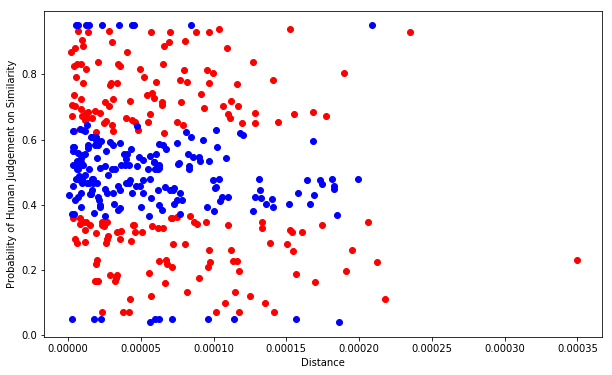

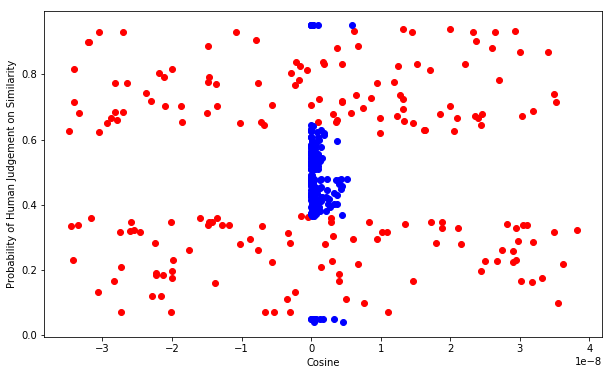

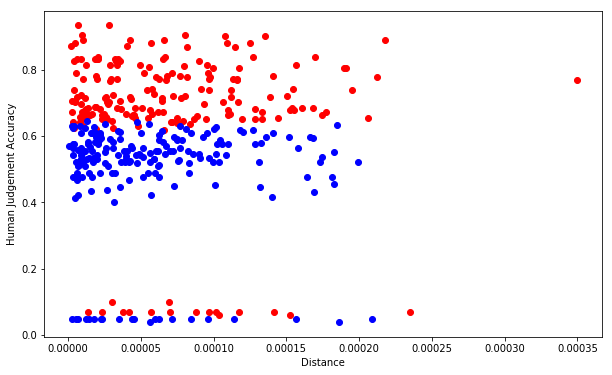

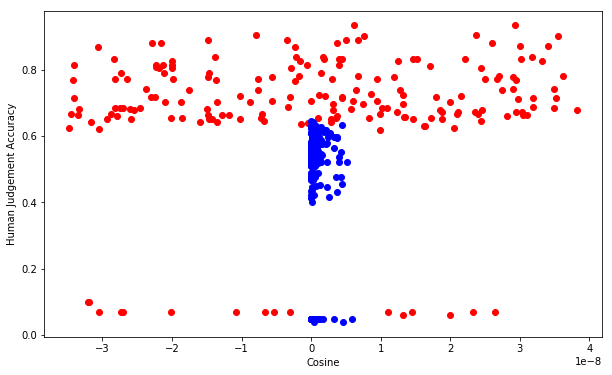

In [36]:
#alpha & beta bottleneck output
#distance, cosine, prob_human_similarity, accuracy
encode_output_distance = []
encode_output_distance.extend(encode_output_alpha_distance)
encode_output_distance.extend(encode_output_beta_distance)

encode_output_cosine = []
encode_output_cosine.extend(encode_output_alpha_cosine)
encode_output_cosine.extend(encode_output_beta_cosine)

prob_human_similarity = []
prob_human_similarity.extend(art_data.alpha_prob_human_similarity)
prob_human_similarity.extend(art_data.beta_prob_human_similarity)

accuracy = []
accuracy.extend(art_data.alpha_accuracy)
accuracy.extend(art_data.alpha_accuracy)

plot_4lists(encode_output_alpha_distance, art_data.alpha_prob_human_similarity,
            encode_output_beta_distance, art_data.beta_prob_human_similarity,
            "Distance", "Probability of Human Judgement on Similarity")
plot_4lists(encode_output_alpha_cosine, art_data.alpha_prob_human_similarity,
            encode_output_beta_cosine, art_data.beta_prob_human_similarity,
            "Cosine", "Probability of Human Judgement on Similarity")

plot_4lists(encode_output_alpha_distance, art_data.alpha_accuracy,
            encode_output_beta_distance, art_data.beta_accuracy,
            "Distance", "Human Judgement Accuracy")
plot_4lists(encode_output_alpha_cosine, art_data.alpha_accuracy,
            encode_output_beta_cosine, art_data.beta_accuracy,
            "Cosine", "Human Judgement Accuracy")

In [37]:
#alpha & beta, bottlenect output
#distance, prob_human_similarity
spearmanr(encode_output_distance, prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.17378574219310228, pvalue=0.00062517276062185598)

In [38]:
#alpha & beta, bottlenect output
#cosine, prob_human_similarity
spearmanr(encode_output_cosine, prob_human_similarity, axis=None)

SpearmanrResult(correlation=0.0056961716186752047, pvalue=0.9114111912873244)

In [39]:
#alpha & beta, bottlenect output
#distance, accuracy
spearmanr(encode_output_distance, accuracy, axis=None)

SpearmanrResult(correlation=0.038401004695557642, pvalue=0.45305808633777345)

In [40]:
#alpha & beta, bottlenect output
#cosine, accuracy
spearmanr(encode_output_cosine, accuracy, axis=None)

SpearmanrResult(correlation=0.075581479473198182, pvalue=0.13930735372337233)

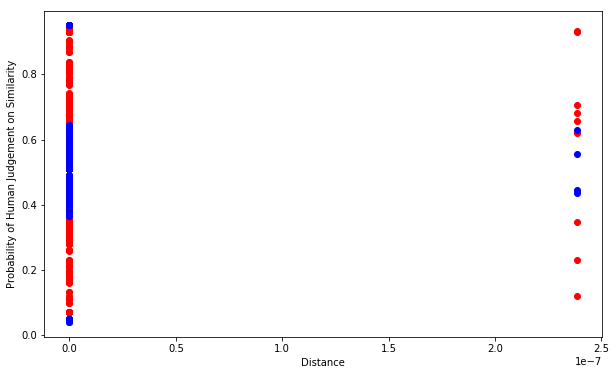

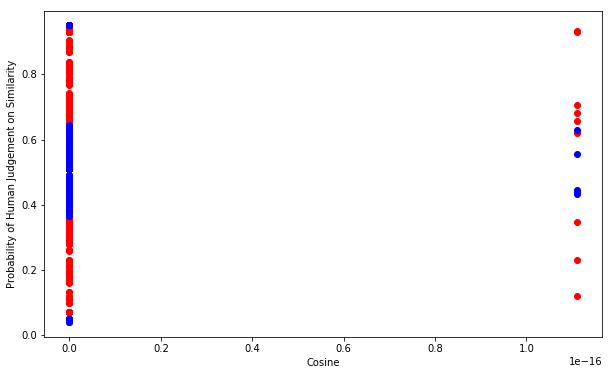

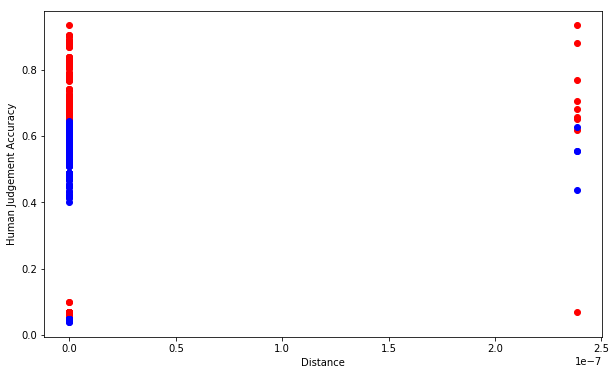

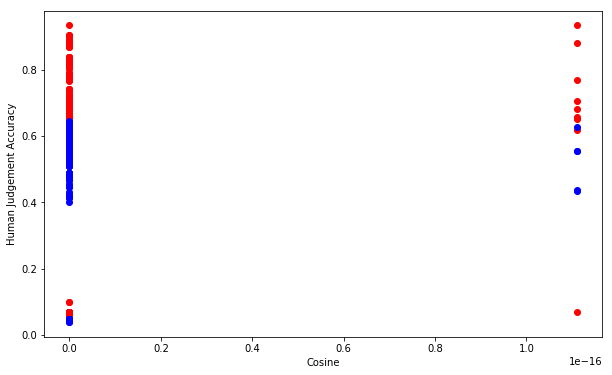

In [41]:
#alpha & beta network output
#distance, cosine, prob_human_similarity, accuracy
encode_decode_output_distance = []
encode_decode_output_distance.extend(encode_decode_output_alpha_distance)
encode_decode_output_distance.extend(encode_decode_output_beta_distance)

encode_decode_output_cosine = []
encode_decode_output_cosine.extend(encode_decode_output_alpha_cosine)
encode_decode_output_cosine.extend(encode_decode_output_beta_cosine)

'''
prob_human_similarity = []
prob_human_similarity.extend(art_data.alpha_prob_human_similarity)
prob_human_similarity.extend(art_data.beta_prob_human_similarity)

accuracy = []
accuracy.extend(art_data.alpha_accuracy)
accuracy.extend(art_data.alpha_accuracy)
'''

plot_4lists(encode_decode_output_alpha_distance, art_data.alpha_prob_human_similarity,
            encode_decode_output_beta_distance, art_data.beta_prob_human_similarity,
            "Distance", "Probability of Human Judgement on Similarity")
plot_4lists(encode_decode_output_alpha_cosine, art_data.alpha_prob_human_similarity,
            encode_decode_output_beta_cosine, art_data.beta_prob_human_similarity,
            "Cosine", "Probability of Human Judgement on Similarity")

plot_4lists(encode_decode_output_alpha_distance, art_data.alpha_accuracy,
            encode_decode_output_beta_distance, art_data.beta_accuracy,
            "Distance", "Human Judgement Accuracy")
plot_4lists(encode_decode_output_alpha_cosine, art_data.alpha_accuracy,
            encode_decode_output_beta_cosine, art_data.beta_accuracy,
            "Cosine", "Human Judgement Accuracy")

In [42]:
#alpha & beta, network output
#distance, prob_human_similarity
spearmanr(encode_decode_output_distance, prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.0286007337282712, pvalue=0.57633589878783731)

In [43]:
#alpha & beta, network output
#cosine, prob_human_similarity
spearmanr(encode_decode_output_cosine, prob_human_similarity, axis=None)

SpearmanrResult(correlation=0.043808966409971131, pvalue=0.39194840274762532)

In [44]:
#alpha & beta, network output
#distance, accuracy
spearmanr(encode_decode_output_distance, accuracy, axis=None)

SpearmanrResult(correlation=0.033262095638375268, pvalue=0.51578511008122385)

In [45]:
#alpha & beta, network output
#cosine, accuracy
spearmanr(encode_decode_output_cosine, accuracy, axis=None)

SpearmanrResult(correlation=-0.019059050514158907, pvalue=0.70967260263370457)